In [1]:
#Reading Files#

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

heart = pd.read_csv("heart.csv")
print(heart)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N  

In [5]:
#Cleaning Data#

In [35]:
print(heart.isnull().sum())


print(heart.shape)


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
(918, 12)


In [37]:
target_column_name = 'HeartDisease'
categorical_cols = heart.select_dtypes(include='object').columns.tolist()
heart_encoded = pd.get_dummies(heart, columns=categorical_cols, drop_first=True)


In [67]:
#Logistic Regression#

In [39]:
if target_column_name in heart_encoded.columns:
    X = heart_encoded.drop(target_column_name, axis=1)
    y = heart_encoded[target_column_name]
else:
    exit()

X = X.astype(float)
y = y.astype(float)

def normalize_features(X_train, X_test):
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)

    X_std[X_std == 0] = 1.0

    X_train_norm = (X_train - X_mean) / X_std
    X_test_norm = (X_test - X_mean) / X_std

    X_train_norm = np.nan_to_num(X_train_norm, nan=0.0)
    X_test_norm = np.nan_to_num(X_test_norm, nan=0.0)

    return X_train_norm, X_test_norm, X_mean, X_std


In [41]:
def train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True):
    if len(arrays) == 0:
        raise ValueError("At least one array required.")
    n_samples = len(arrays[0])
    for arr in arrays:
        if len(arr) != n_samples:
            raise ValueError("All input arrays must have the same length.")
    if isinstance(random_state, int):
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random if random_state is None else random_state
    if test_size is None and train_size is None:
        test_size = 0.25
    if test_size is not None:
        n_test = int(np.ceil(test_size * n_samples)) if isinstance(test_size, float) else int(test_size)
    else:
        n_test = n_samples - int(train_size)
    n_train = n_samples - n_test
    indices = rng.permutation(n_samples) if shuffle else np.arange(n_samples)
    train_indices = indices[:n_train]
    test_indices = indices[n_train:]
    result = []
    for arr in arrays:
        arr_np = np.array(arr)
        result.append(arr_np[train_indices])
        result.append(arr_np[test_indices])
    return result

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, X_mean, X_std = normalize_features(X_train_raw, X_test_raw)

In [45]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [47]:
def compute_cost_logistic_reg(X, y, w, b, lambda_=0):
    m = X.shape[0]
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)
    f_wb = np.clip(f_wb, 1e-10, 1 - 1e-10)
    cost = (-1/m) * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    reg_cost = (lambda_ / (2 * m)) * np.sum(w**2)
    total_cost = cost + reg_cost
    return total_cost


In [49]:
def compute_gradient_logistic_reg(X, y, w, b, lambda_=0):
    m, n = X.shape
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)
    error = f_wb - y

    dj_dw = (1/m) * np.dot(X.T, error)
    dj_db = (1/m) * np.sum(error)

    dj_dw += (lambda_ / m) * w

    return dj_dw, dj_db

In [97]:
def gradient_descent_logistic_reg(X, y, w_init, b_init, learning_rate, iterations, lambda_=0):
    w = w_init
    b = b_init
    cost_history = []

    for i in range(iterations):
        dj_dw, dj_db = compute_gradient_logistic_reg(X, y, w, b, lambda_)

        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db

        cost = compute_cost_logistic_reg(X, y, w, b, lambda_)
        cost_history.append(cost)
        #print(f"Iteration {i+1}: Cost = {cost:.4f}, w = [{w}], b = {b:.4f}")

    return w, b, cost_history

w_init = np.zeros(X_train.shape[1])
b_init = 0
learning_rate = 0.01
iterations = 1000

w, b, cost_history = gradient_descent_logistic_reg(X_train, y_train, w_init, b_init, learning_rate, iterations)



In [75]:
def predict_logistic_reg(X, w, b, threshold=0.5):
    z = np.dot(X, w) + b
    probabilities = sigmoid(z)
    return (probabilities >= threshold).astype(int), probabilities
y_pred_train, prob_train = predict_logistic_reg(X_train, w, b)
y_pred_test, prob_test = predict_logistic_reg(X_test, w, b)

In [77]:
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

train_accuracy = calculate_accuracy(y_train, y_pred_train)
test_accuracy = calculate_accuracy(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Training Accuracy: 87.87%
Test Accuracy: 85.33%


In [69]:
#Graphs Required#

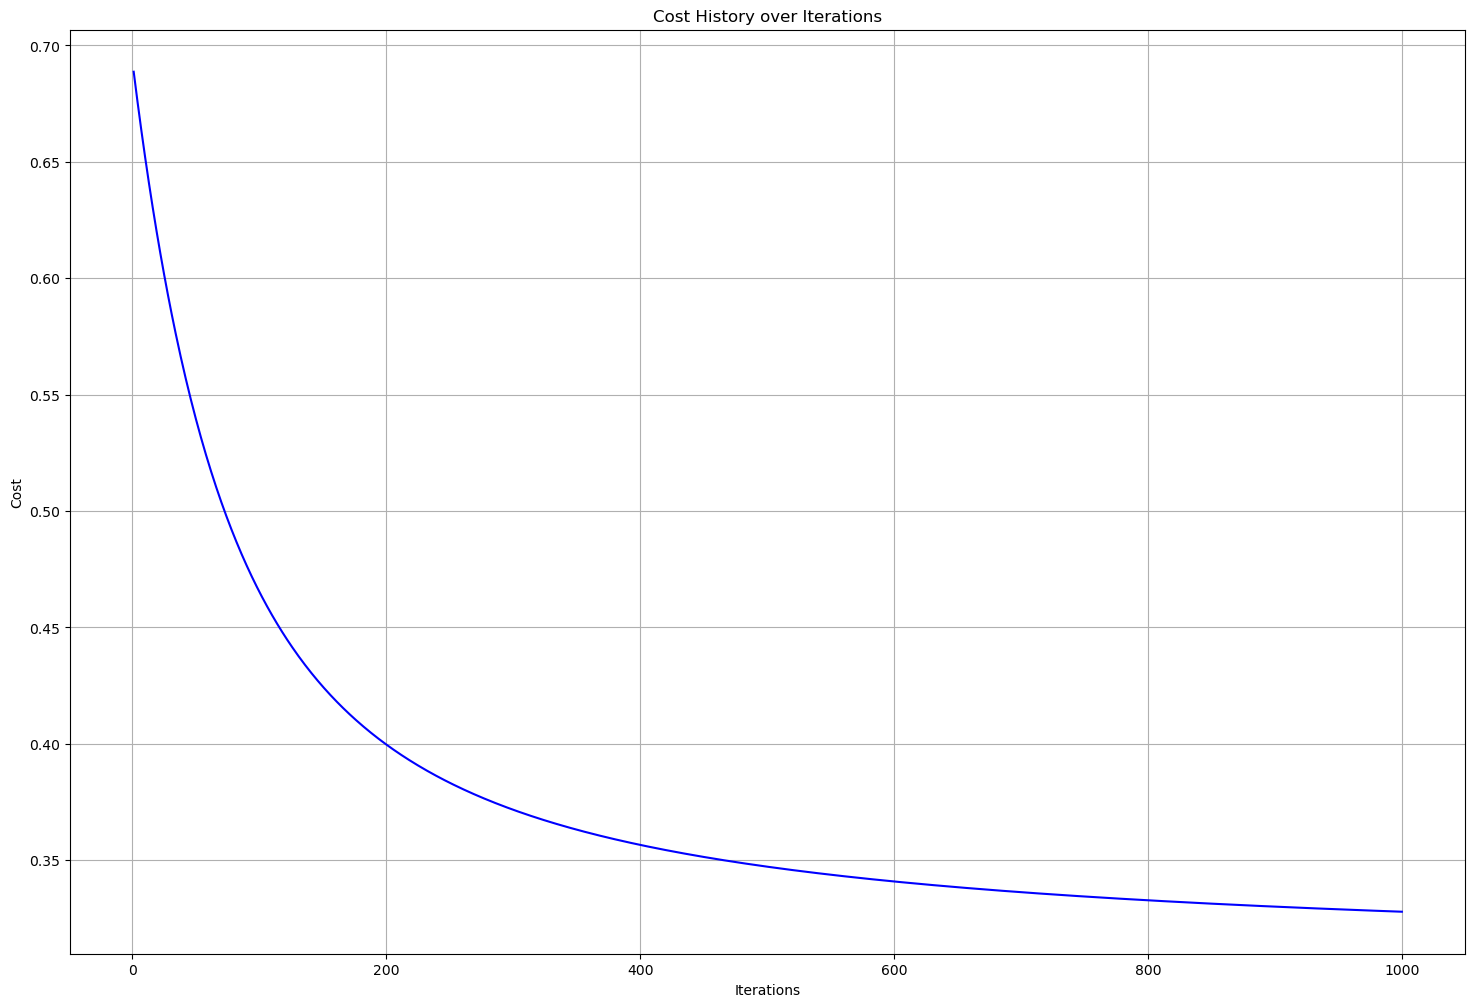

In [95]:
plt.figure(figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)


plt.plot(range(1, iterations + 1), cost_history, color='blue')
plt.title('Cost History over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)

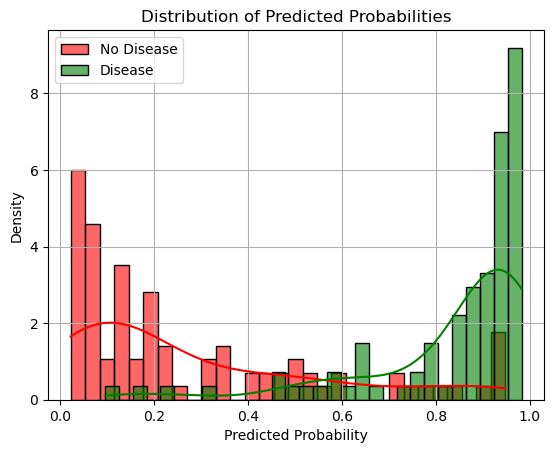

In [87]:
sns.histplot(prob_test[y_test == 0], color='red', label='No Disease', kde=True, stat='density', alpha=0.6, bins=30)
sns.histplot(prob_test[y_test == 1], color='green', label='Disease', kde=True, stat='density', alpha=0.6, bins=30)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

Text(50.72222222222221, 0.5, 'True Label')

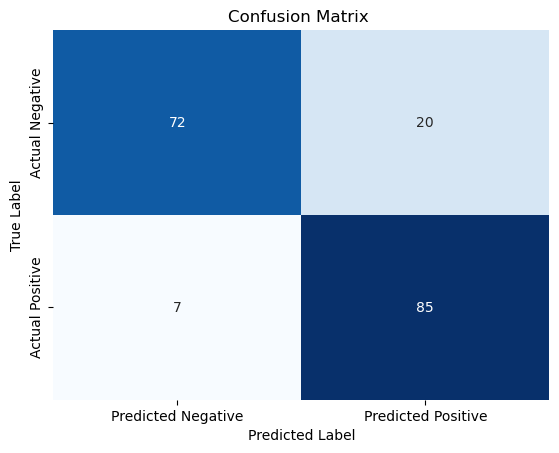

In [89]:
tn = np.sum((y_test == 0) & (y_pred_test == 0))
fp = np.sum((y_test == 0) & (y_pred_test == 1))
fn = np.sum((y_test == 1) & (y_pred_test == 0))
tp = np.sum((y_test == 1) & (y_pred_test == 1))

confusion_matrix = np.array([[tn, fp], [fn, tp]])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


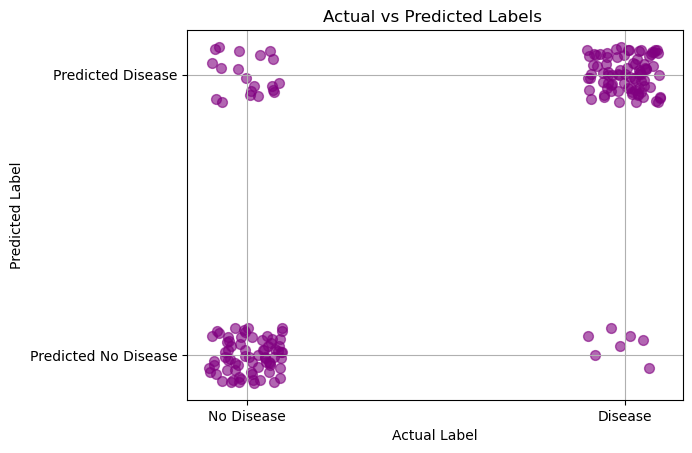

In [93]:
plt.scatter(y_test + np.random.uniform(-0.1, 0.1, size=len(y_test)),
            y_pred_test + np.random.uniform(-0.1, 0.1, size=len(y_pred_test)),
            alpha=0.6, s=50, c='purple')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.yticks([0, 1], ['Predicted No Disease', 'Predicted Disease'])
plt.title('Actual vs Predicted Labels ')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.grid()

plt.show()